In [415]:
import numpy as np
import torch
from torchvision import transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.autograd import Variable 
torch.manual_seed(1)
np.random.seed(1)
import matplotlib.pyplot as plt

# For importing poses
import sys
import os
sys.path.append(os.path.expanduser("/workspace/code/corelibs/src/tools-python"))
sys.path.append(os.path.expanduser("/workspace/code/corelibs/build/datatypes"))
sys.path.append(os.path.expanduser("/workspace/code/corelibs/build/datatypes/datatypes_python"))

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

In [416]:
# Open monolithic and iterate frames
dataset_path = "/workspace/data/pose-prediction-odometry/"
RO_relative_poses_path = dataset_path+"ro_relative_poses.monolithic"
print("reading RO_relative_poses_path: " + RO_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    RO_relative_poses_path)

# iterate mono
RO_se3s = []
RO_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    RO_se3s.append(serialised_transform[0])
    RO_timestamps.append(serialised_transform[1])
print("Finished reading",len(RO_timestamps),"poses.")

reading RO_relative_poses_path: /workspace/data/pose-prediction-odometry/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2
Finished reading 479 poses.


In [417]:
t_x_data = np.zeros(len(RO_timestamps))
t_y_data = np.zeros(len(RO_timestamps))
t_theta_data = np.zeros(len(RO_timestamps))

for i in range(len(RO_timestamps)):
    t_x_data[i] = RO_se3s[i][0,3]
    t_y_data[i] = RO_se3s[i][1,3]
    t_theta_data[i] = np.arccos(RO_se3s[i][0,0])

In [418]:
num_features = 3
num_frames = 3
input_size = num_features * num_frames
output_size = num_features

479
478
477


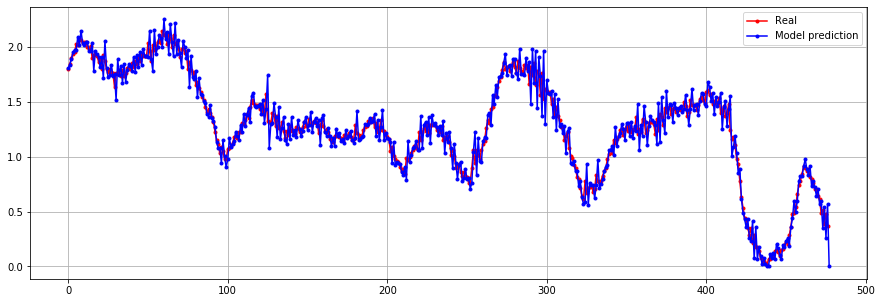

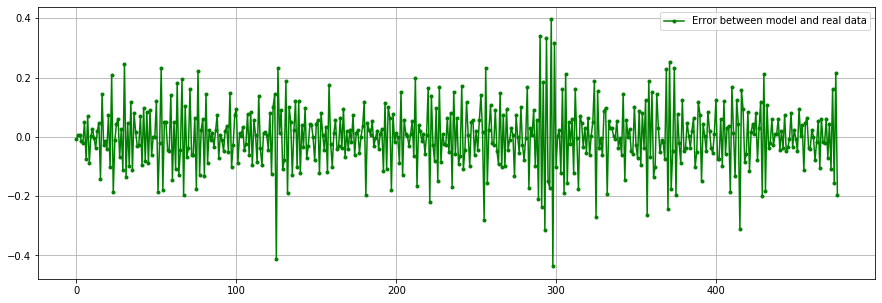

In [419]:
pred_poses = []

for i in range(len(RO_se3s)-1):
    future_pose = RO_se3s[i+1]*(RO_se3s[i+1]*np.linalg.inv(RO_se3s[i]))
    pred_poses.append(future_pose)

dim1_data = np.zeros(len(pred_poses)-1)
dim2_data = np.zeros(len(pred_poses)-1)
dim3_data = np.zeros(len(pred_poses)-1)

poses_x = np.zeros(len(pred_poses))
poses_y = np.zeros(len(pred_poses))
poses_theta = np.zeros(len(pred_poses))

for i in range(len(dim1_data)):
    poses_x[i] = pred_poses[i][0,3]
    poses_y[i] = pred_poses[i][1,3]
    poses_theta[i] = np.arccos(pred_poses[i][0,0])
    
    dim1_data[i] = RO_se3s[i+2][0,3] - pred_poses[i][0,3]
    dim2_data[i] = RO_se3s[i+2][1,3] - pred_poses[i][1,3]
    dim3_data[i] = np.arccos(RO_se3s[i+2][0,0]) - np.arccos(pred_poses[i][0,0])

print(len(RO_se3s))
print(len(pred_poses))
print(len(dim1_data))    

plt.figure(figsize=(15,5))
plt.plot(t_x_data[2:],'r.-',label='Real') # cropping first 2 frames here to align plots
plt.plot(poses_x,'b.-',label='Model prediction')
plt.legend()
plt.grid()

plt.figure(figsize=(15,5))
plt.plot(dim1_data,'g.-',label='Error between model and real data')
plt.legend()
plt.grid()

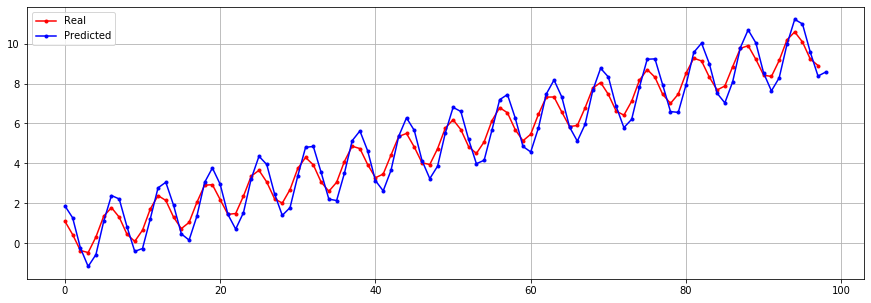

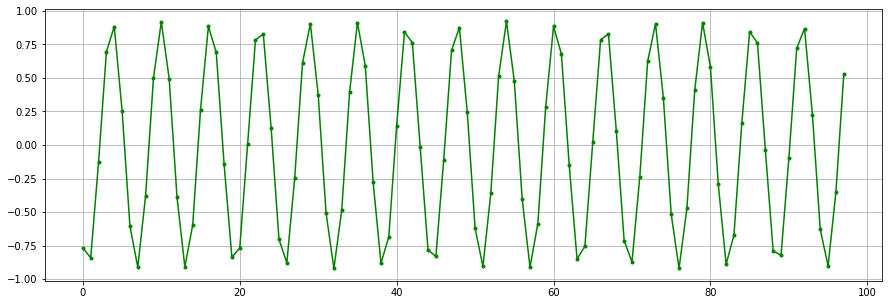

In [420]:
use_toy_data = True
if(use_toy_data):
    # Creating the artificial dataset
    t_x_data = np.arange(0,10,0.1)
    t_y_data = np.arange(0,1,0.01)
    t_theta_data = np.arange(0,0.1,0.001)

    # adding noise
    for i in range(len(t_x_data)):
        t_x_data[i] += np.sin(i) + np.random.randn()*0.001
        t_y_data[i] += np.sin(i)*0.1 + np.random.randn()*0.0001
        t_theta_data[i] += np.sin(i)*0.01 + np.random.randn()*0.00001

    t_x_pred = []
    t_x_model_err = []
    t_y_pred = []
    t_y_model_err = []
    t_theta_pred = []
    t_theta_model_err = []

    for i in range(len(t_x_data)-1):
        t_x_pred.append(t_x_data[i+1] + (t_x_data[i+1] - t_x_data[i]))
        t_y_pred.append(t_y_data[i+1] + (t_y_data[i+1] - t_y_data[i]))
        t_theta_pred.append(t_theta_data[i+1] + (t_theta_data[i+1] - t_theta_data[i]))
        
    for i in range(len(t_x_pred)-1):
        t_x_model_err.append(t_x_data[i+2] - t_x_pred[i])
        t_y_model_err.append(t_y_data[i+2] - t_y_pred[i])
        t_theta_model_err.append(t_theta_data[i+2] - t_theta_pred[i])

    plt.figure(figsize=(15,5))
    plt.plot(t_x_data[2:],'r.-')
    plt.plot(t_x_pred,'b.-')
    plt.legend(["Real","Predicted"])
    plt.grid()

    plt.figure(figsize=(15,5))
    plt.plot(t_x_model_err,'g.-')
    plt.grid()
    
    # hack to allow the rest of the code to remain the same
    dim1_data = np.array(t_x_model_err)
    poses_x = np.array(t_x_pred)
    dim2_data = np.array(t_y_model_err)
    poses_y = np.array(t_y_pred)
    dim3_data = np.array(t_theta_model_err)
    poses_theta = np.array(t_theta_pred)

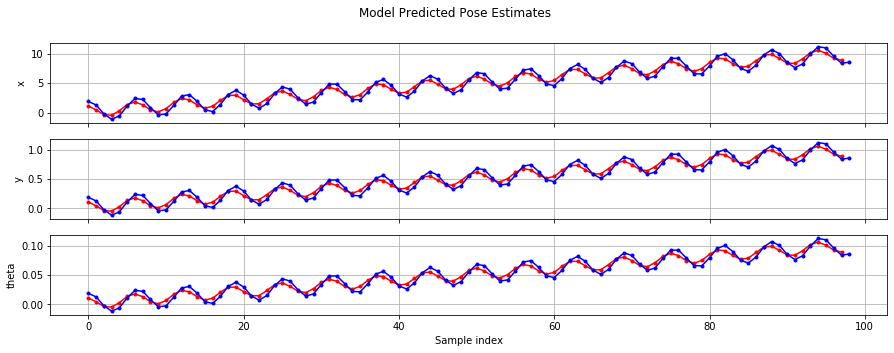

In [421]:
# Plot subfigures
fig,axs = plt.subplots(3,figsize=(15,5))
fig.suptitle('Model Predicted Pose Estimates')
axs[0].plot(t_x_data[2:],'r.-')
axs[0].plot(poses_x,'b.-')
axs[0].set(ylabel = 'x')
axs[1].plot(t_y_data[2:],'r.-')
axs[1].plot(poses_y,'b.-')
axs[1].set(ylabel = 'y')
axs[2].plot(t_theta_data[2:],'r.-')
axs[2].plot(poses_theta,'b.-')
axs[2].set(ylabel = 'theta')
for ax in axs.flat:
    ax.set(xlabel='Sample index')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

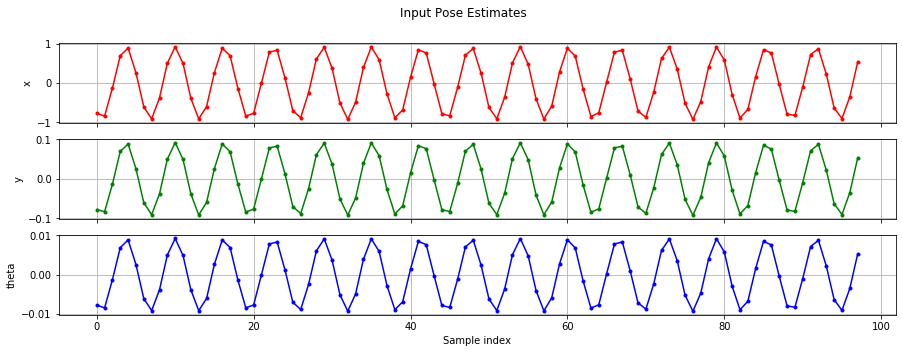

In [422]:
dim1_data_scaled = (dim1_data - dim1_data.mean())/dim1_data.std()
dim2_data_scaled = (dim2_data - dim2_data.mean())/dim2_data.std()
dim3_data_scaled = (dim3_data - dim3_data.mean())/dim3_data.std()

# Plot subfigures
fig,axs = plt.subplots(3,figsize=(15,5))
fig.suptitle('Input Pose Estimates')
axs[0].plot(dim1_data,'r.-')
axs[0].set(ylabel = 'x')
axs[1].plot(dim2_data,'g.-')
axs[1].set(ylabel = 'y')
axs[2].plot(dim3_data,'b.-')
axs[2].set(ylabel = 'theta')
for ax in axs.flat:
    ax.set(xlabel='Sample index')
    ax.grid()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [423]:
# For the two frame case, input tensor holds x, y, and theta data in frame 1, frame 2
# [x1,y1,th1,x2,y2,th2]
# These are offset, so that x1 goes up until the second last frame
# (current frame is treated as future prediction)

# output tensor holds single frame, for x, y, and theta values
# This is cropped to exclude the first n frames (n=2 here) and run up until the end
# So a synthesised 'future' value to aim for

t_x = torch.tensor(dim1_data_scaled)
t_y = torch.tensor(dim2_data_scaled)
t_theta = torch.tensor(dim3_data_scaled)

x_data = torch.zeros(len(dim1_data)-num_frames,input_size)
start_idx = 0
end_idx = len(x_data)
frame_idx = num_frames - 1

for i in range(num_frames):
    x_data[:,frame_idx*num_features+2] = t_theta[start_idx:end_idx]
    x_data[:,frame_idx*num_features+1] = t_y[start_idx:end_idx]
    x_data[:,frame_idx*num_features] = t_x[start_idx:end_idx]
    start_idx+=1
    end_idx+=1
    frame_idx-=1 # older frames are assigned to later columns
    
y_data = torch.zeros(len(dim1_data)-num_frames,output_size)
y_data[:,0] = t_x[num_frames:]
y_data[:,1] = t_y[num_frames:]
y_data[:,2] = t_theta[num_frames:]

In [424]:
x_rows = x_data.size()[0]
train_validate_ratio = 0.8
training_idx_limit = int(train_validate_ratio * x_rows)

x_train = x_data[:training_idx_limit,:]
x_valid = x_data[training_idx_limit:,:]

y_train = y_data[:training_idx_limit,:]
y_valid = y_data[training_idx_limit:,:]

print('x_data dimensions:',x_data.size())
print('x_train dimensions:',x_train.size())
print('x_valid dimensions:',x_valid.size())
print('y_data dimensions:',y_data.size())
print('y_train dimensions:',y_train.size())
print('y_valid dimensions:',y_valid.size())

x_data dimensions: torch.Size([95, 9])
x_train dimensions: torch.Size([76, 9])
x_valid dimensions: torch.Size([19, 9])
y_data dimensions: torch.Size([95, 3])
y_train dimensions: torch.Size([76, 3])
y_valid dimensions: torch.Size([19, 3])


In [425]:
class Pose_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(input_size,output_size)

    def forward(self, xb):
        return self.lin(xb)
    
epochs = 50
lr = 1e-1
batch_size = 30

model = Pose_Logistic()
criterion = nn.MSELoss()
Loss = []  # variable for storing losses after each epoch

train_ds = TensorDataset(x_train,y_train)
valid_ds = TensorDataset(x_valid,y_valid)

def loss_batch(model,loss_func,xb,yb,opt=None):
    loss=loss_func(model(xb),yb)
    
    if opt is not None:
        Loss.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(),len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

def get_model():
    model = Pose_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [426]:
loss_func = criterion

train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.2533048391342163
1 0.04373675584793091
2 0.013228004798293114
3 0.006575589068233967
4 0.004075879231095314
5 0.0026630430947989225
6 0.0017498360248282552
7 0.0011718933237716556
8 0.0007720097783021629
9 0.0005209314986132085
10 0.00035403697984293103
11 0.0002436165086692199
12 0.00016931149002630264
13 0.00012007854820694774
14 8.799093484412879e-05
15 6.707679131068289e-05
16 5.166461778571829e-05
17 4.260269270162098e-05
18 3.611510692280717e-05
19 3.157391620334238e-05
20 2.8608190405066125e-05
21 2.682926060515456e-05
22 2.5831277525867335e-05
23 2.5250403268728405e-05
24 2.433356348774396e-05
25 2.3929766030050814e-05
26 2.3634695025975816e-05
27 2.3445723854820244e-05
28 2.323950502614025e-05
29 2.3204838726087473e-05
30 2.330984170839656e-05
31 2.323106127732899e-05
32 2.295615922776051e-05
33 2.3116246666177176e-05
34 2.3224969481816515e-05
35 2.3275251805898733e-05
36 2.293918987561483e-05
37 2.292782664881088e-05
38 2.3228225472848862e-05
39 2.2920810806681402e-05
40 

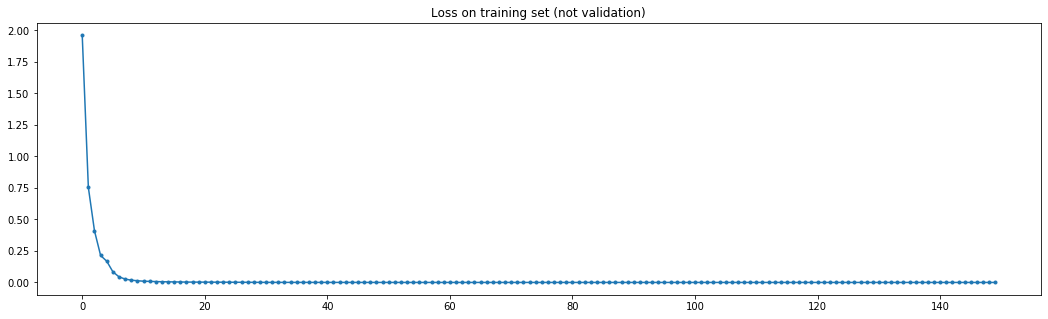

In [427]:
plt.figure(figsize=(18,5))
plt.title("Loss on training set (not validation)")
plt.plot(Loss,'.-')

In [432]:
# Prediction frame, just for sanity checking (not proper testing)
idx = 60
query_dim1 = []
query_dim2 = []
query_dim3 = []

newest_frame_remaining = num_frames - 1
for i in range(num_frames):
    query_dim1.append(dim1_data[idx+newest_frame_remaining])
    query_dim2.append(dim2_data[idx+newest_frame_remaining])
    query_dim3.append(dim3_data[idx+newest_frame_remaining])
    
    print(newest_frame_remaining)
    newest_frame_remaining -= 1

print(query_dim1)

scaled_query_dim1 = (query_dim1 - dim1_data.mean())/dim1_data.std()
scaled_query_dim2 = (query_dim2 - dim2_data.mean())/dim2_data.std()
scaled_query_dim3 = (query_dim3 - dim3_data.mean())/dim3_data.std()

# Build combination so x, y, and theta are adjacent for 1 pose
c = np.empty(scaled_query_dim1.size + scaled_query_dim2.size + scaled_query_dim3.size)
c[0::num_features] = scaled_query_dim1
c[1::num_features] = scaled_query_dim2
c[2::num_features] = scaled_query_dim3

new_query = Variable(torch.Tensor([c]))
print(new_query)

answer = model(new_query)
print('\n raw answer:\n',answer)
print('\n scaled up again:')
print((answer[0][0]*dim1_data.std() + dim1_data.mean()).data)
print((answer[0][1]*dim2_data.std() + dim2_data.mean()).data)
print((answer[0][2]*dim3_data.std() + dim3_data.mean()).data)
print('True answer:',dim1_data[idx+num_frames],dim2_data[idx+num_frames],dim3_data[idx+num_frames])

2
1
0
[-0.15125241384559196, 0.6796939145784071, 0.8849479728416547]
tensor([[-0.2129, -0.2182, -0.2165,  1.0655,  1.0660,  1.0638,  1.3813,  1.3872,
          1.3891]])

 raw answer:
 tensor([[-1.2819, -1.2820, -1.2817]], grad_fn=<AddmmBackward>)

 scaled up again:
tensor(-0.8461)
tensor(-0.0847)
tensor(-0.0085)
True answer: -0.8513775650617168 -0.08463271521475035 -0.00846396021272848
